<a href="https://colab.research.google.com/github/skosch/YinYangFit/blob/master/YinYangFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up TF2 and import dependencies

In [0]:
try:
  # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    #%tensorflow_version 1.x
except Exception:
    pass

TensorFlow 2.x selected.


In [0]:
import itertools
import os

import numpy as np
pi = np.pi
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.interpolation import affine_transform
import tensorflow as tf
import random; random.seed()
import math
import pickle
import os
from tqdm import tqdm as tqdm
import sys
from functools import reduce
import random
from itertools import cycle, islice, product
import operator

!pip install --quiet --upgrade git+git://github.com/simoncozens/tensorfont.git
!pip install --quiet fonttools

from tensorfont import Font

print("✓ Dependencies imported.")

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

     |████████████████████████████████| 890kB 4.8MB/s 
     |████████████████████████████████| 727kB 4.7MB/s 
✓ Dependencies imported.
TF version: 2.0.0
GPU is available


### Download font files

In [0]:
#!wget -q -O OpenSans-Regular.ttf https://github.com/googlefonts/opensans/blob/master/ttfs/OpenSans-Regular.ttf?raw=true
!wget -q -O Roboto.ttf https://github.com/google/fonts/blob/master/apache/roboto/Roboto-Regular.ttf?raw=true
#!wget -q -O Roboto.otf https://github.com/AllThingsSmitty/fonts/blob/master/Roboto/Roboto-Regular/Roboto-Regular.otf?raw=true
!wget -q -O DroidSerif.ttf https://github.com/datactivist/sudweb/blob/master/fonts/droid-serif-v6-latin-regular.ttf?raw=true
!wget -q -O CrimsonItalic.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Italic.otf?raw=true
#!wget -q -O CrimsonBold.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Bold.otf?raw=true 
#!wget -q -O CrimsonRoman.otf https://github.com/alif-type/amiri/blob/master/Amiri-Regular.ttf?raw=true

!wget -q -O CrimsonRoman.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Roman.otf?raw=true
print("✓ Font file(s) downloaded.")

✓ Font file(s) downloaded.


## Load font data and set up global parameters

In [0]:
glyph_char_list = "abcdeghijlmnopqrstuzywvxkf"
#glyph_char_list = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

# ==== Create Font ====
factor = 1.1 #1.539  # This scales the size of everything
f = Font("CrimsonRoman.otf", 34 * factor) # Roboto.ttf CrimsonRoman.otf
box_height = f.full_height_px
box_width = int(122 * factor)
box_width += (box_width + 1) % 2
print("Box size:", box_height, "×", box_width)

batch_size = 1  # must be divisible by 8 to work on TPU
n_sample_distances = 9 # should be an odd number

n_sizes = 5
n_pseudo_orientations = 4
n_orientations = 4

Box size: 88 × 135


## Create Gabor filter bank

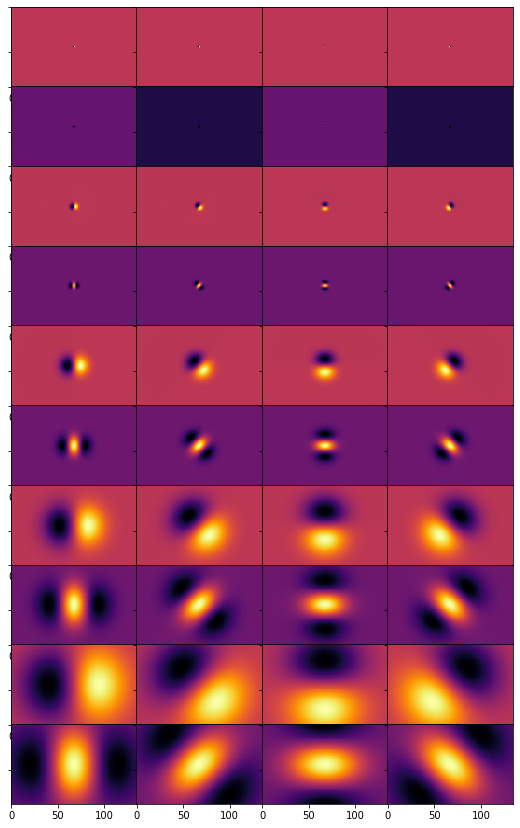

In [0]:
def get_3n_filters(skip_scales, display_filters=False):
    def rotated_mgrid(oi):
        """Generate a meshgrid and rotate it by RotRad radians."""
        rotation = np.array([[ np.cos(pi*oi/n_orientations), np.sin(pi*oi/n_orientations)],
                             [-np.sin(pi*oi/n_orientations), np.cos(pi*oi/n_orientations)]])
        hh = box_height / 2
        bw = box_width / 2
        y, x = np.mgrid[-hh:hh, -bw:bw]
        y += 0 if box_height % 2 == 0 else 0.5
        x += 0 if box_width % 2 == 0 else 0.5
        return np.einsum('ji, mni -> jmn', rotation, np.dstack([x, y]))

    def get_filter(sigma, theta):
        x, y = rotated_mgrid(theta)

        # To minimize ringing etc., we create the filter as is, then run it through the DFT.
        a1 = 0.25 # See Georgeson et al. 2007
        s1 = sigma #a1 * sigma
        d1_space = -np.exp(-(x**2+y**2)/(2*s1**2))*x/(2*pi*s1**4)
        d1 = np.fft.fft2(d1_space + 1j * np.zeros_like(d1_space)) #, [box_height, box_width])

        # Second derivative:
        s2 = sigma #np.sqrt(1. - a1**2) * sigma # See Georgeson et al. (2007)
        d2_space = np.exp(-(x**2+y**2)/(2*s2**2))/(2*pi*s2**4) - np.exp(-(x**2+y**2)/(2*s2**2))*x**2/(2*pi*s2**6)
        d2 = sigma**1.5 * np.fft.fft2(d2_space + 1j * np.zeros_like(d2_space)) #, [box_height, box_width])

        # For now: d1 is complex(-d2,d1)
        d1c = 1j * (d2 + 1j*d1) * sigma
        return (d1c, d2)

    d1_bank = np.zeros((n_sizes, n_orientations, box_height, box_width)).astype(np.complex64)
    d2_bank = np.zeros((n_sizes, n_orientations, box_height, box_width)).astype(np.complex64)

    if display_filters:
        sizediv = 60
        fig, ax = plt.subplots(nrows=n_sizes*2, ncols=n_orientations, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_orientations / sizediv, box_height * n_sizes * 2 / sizediv))

    for s in range(n_sizes):
        min_sigma = 0.5
        max_sigma = box_width / 5.
        sigma = (max_sigma - min_sigma) * (s + skip_scales)**2 / (n_sizes - 1)**2 + min_sigma
        for o in range(n_orientations):
            (d1, d2) = get_filter(sigma, o)
            if display_filters:
                ax[s*2,   o].imshow(np.real(np.fft.ifft2(d1)), cmap="inferno")
                ax[s*2, o].set_aspect("auto")
                ax[s*2, o].set_yticklabels([])
                ax[s*2+1, o].imshow(np.imag(np.fft.ifft2(d1)), cmap="inferno")
                ax[s*2+1, o].set_aspect("auto")
                ax[s*2+1, o].set_yticklabels([])
            d1_bank[s, o, :, :] = d1
            d2_bank[s, o, :, :] = d2

    if display_filters:
        plt.show()

    return (d1_bank, d2_bank)

d1_filter_bank, d2_filter_bank = get_3n_filters(0, True)

## Rasterize the glyphs into numpy arrays, and extract their ink widths in pixels


In [0]:
def apply_filter_bank(input_image, filter_bank):
    """
    Input image should have dimensions <h, w> or <s, o, h, w> or <b, s, o, h, w, d>.
    Filter bank should have dimensions <s, o, h, w>
    """
    if len(input_image.shape) == 2:
        bdsohw_input_image = input_image[None, None, None, None, :, :]
    elif len(input_image.shape) == 4:
        bdsohw_input_image = input_image[None, None, :, :, :, :]
    elif len(input_image.shape) == 6:
        bdsohw_input_image = tf.einsum("bsohwd->bdsohw", input_image)

    input_in_freqdomain = tf.signal.fft2d(tf.complex(bdsohw_input_image, tf.zeros_like(bdsohw_input_image)))
                                             
    result = (tf.signal.ifft2d(input_in_freqdomain * filter_bank[None, None, :, :, :, :]))

    if len(input_image.shape) == 2:
        return tf.signal.fftshift(result[0, 0, :, :, :, :], axes=[-2, -1])
    elif len(input_image.shape) == 4:
        return tf.signal.fftshift(result[0, 0, :, :, :, :], axes=[-2, -1])
    elif len(input_image.shape) == 6:
        return tf.einsum("bdsohw->bsohwd", tf.signal.fftshift(result, axes=[-2, -1]))

def get_glyph_data_with_filtered_as_dict(glyph_char):
    """
    Returns a dict containing relevant glyph data, including filtered images.
    @param glyph_char: string of length 1
    """
    glyph_image = f.glyph(glyph_char).as_matrix(normalize=True).with_padding_to_constant_box_width(box_width).astype(np.float32)

    return {
        'glyph_char': glyph_char,
        'glyph_image': glyph_image,
        'glyph_ink_width': f.glyph(glyph_char).ink_width,
        'glyph_d1_filtered_images': apply_filter_bank(glyph_image, d1_filter_bank),
    }

def get_sample_distances_and_translations(gd1, gd2, target_ink_distance):
    """Returns a list of distances at which the box images have to be shifted left and right before they can be overlaid to sample their normalized interaction"""
    total_width_at_minimum_ink_distance = gd1['glyph_ink_width'] + gd2['glyph_ink_width'] - f.minimum_ink_distance(gd1['glyph_char'], gd2['glyph_char'])
    
    relative_sample_distances = [0]
    simax = int((n_sample_distances - 1)/2)
    
    pos_ad = 1 #factor / 2.
    neg_ad = -1 #((target_ink_distance / simax))
    next_pos = pos_ad
    next_neg = neg_ad
    for si in range(simax):
        # always append a positive, and then ...
        relative_sample_distances.append(next_pos)
        next_pos += pos_ad
        pos_ad *= 1#.15
        # ... append a negative only if there is room
        if target_ink_distance + next_neg >= 1:
            relative_sample_distances.append(next_neg)
            next_neg += neg_ad
        else:
            relative_sample_distances.append(next_pos)
            next_pos += pos_ad
            pos_ad *= 1.15
    
    relative_sample_distances.sort()
    
    zero_index_val = relative_sample_distances.index(0)
    
    sample_distances = (np.array(relative_sample_distances) + target_ink_distance)
    sample_distances_left = np.ceil(sample_distances / 2)
    sample_distances_right = np.floor(sample_distances / 2)
    
    total_ink_width = gd1['glyph_ink_width'] + gd2['glyph_ink_width']
    ink_width_left = np.floor(total_ink_width / 4)
    ink_width_right = np.ceil(total_ink_width / 4)
    
    left_translations = (-(np.ceil(total_width_at_minimum_ink_distance/2) + sample_distances_left) - (-ink_width_left)).astype(np.int32)
    right_translations = ((np.floor(total_width_at_minimum_ink_distance/2) + sample_distances_right) - ink_width_right).astype(np.int32)

    return {
        'sample_distances': sample_distances,
        'relative_sample_distances': relative_sample_distances,
        'left_translations': left_translations,
        'right_translations': right_translations,
        'zero_index': zero_index_val
    }

def shift_sohw1_into_sohwd(input_images, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param images: <sizes, orientations, height, width, 1>
    @param translations: <len(translations)>
    @output        <sizes, orientations, height, width, len(translations)>
    """
    images = tf.tile(input_images, [1, 1, 1, 1, translations.shape[0]]) # create len(shifts) channel copies
    fill_constant = 0
    left = tf.maximum(0, tf.reduce_max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right = -tf.minimum(0, tf.reduce_min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], left, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    right_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], right, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    padded_images = tf.concat([left_mask, images, right_mask], axis=3) # pad on axis 3 (i.e. width-wise)

    # Now that the images are all padded, we need to crop them to implement the shifts.
    def crop_image_widthwise(image_and_shift):
        image = image_and_shift[0] # sohw
        shift = image_and_shift[1] # 
        return image[:, :, :, left-shift:left-shift+input_images.shape[3]] # positive shift: left-shift

    return tf.einsum("dsohw->sohwd", tf.map_fn(
        crop_image_widthwise,
        (tf.einsum("sohwd->dsohw", padded_images), translations),
        dtype=images.dtype))

def shift_hwso1_into_hwsod(input_images, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param images: <height, width, sizes, orientations, 1>
    @param translations: <len(translations)>
    @output        <height, width, sizes, orientations, len(translations)>
    """
    images = tf.tile(input_images, [1, 1, 1, 1, translations.shape[0]]) # create len(shifts) channel copies
    fill_constant = 0
    left = tf.maximum(0, tf.reduce_max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right = -tf.minimum(0, tf.reduce_min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = tf.ones(shape=(tf.shape(images)[0], left, tf.shape(images)[2], tf.shape(images)[3], tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    right_mask = tf.ones(shape=(tf.shape(images)[0], right, tf.shape(images)[2], tf.shape(images)[3], tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    padded_images = tf.concat([left_mask, images, right_mask], axis=1) # pad on axis 2 (i.e. width-wise)

    # Now that the images are all padded, we need to crop them to implement the shifts.
    def crop_image_widthwise(image_and_shift):
        image = image_and_shift[0]
        shift = image_and_shift[1]
        return image[:, left-shift:left-shift+input_images.shape[1], :, :] # positive shift: left-shift

    return tf.einsum("dhwso->hwsod", tf.map_fn(
        crop_image_widthwise,
        (tf.einsum("hwsod->dhwso", padded_images), translations),
        dtype=images.dtype))

def shift_and_overlay_pair_data(gd1, gd2):
    """
    Returns a 5D tensor <box_height, box_width, sizes, orientations, distances>.
    """

    target_ink_distance = int(f.pair_distance(gd1['glyph_char'], gd2['glyph_char']) + f.minimum_ink_distance(gd1['glyph_char'], gd2['glyph_char']))
    sdt = get_sample_distances_and_translations(gd1, gd2, target_ink_distance)

    shifted_gd1_d1_filtered_images = shift_sohw1_into_sohwd(gd1['glyph_d1_filtered_images'][..., None], sdt['left_translations'])
    shifted_gd2_d1_filtered_images = shift_sohw1_into_sohwd(gd2['glyph_d1_filtered_images'][..., None], sdt['right_translations'])

    # We want to shift both the original images (for display purposes only), as well as the filtered images.
    pair_images = (shift_hwso1_into_hwsod(gd1['glyph_image'][..., None, None, None], sdt['left_translations']) + 
                   shift_hwso1_into_hwsod(gd2['glyph_image'][..., None, None, None], sdt['right_translations']))[:, :, 0, 0, :]
    zero_index = sdt['zero_index']
    sample_distances = sdt['sample_distances']

    return  {
        'shifted_gd1_d1_filtered_images': shifted_gd1_d1_filtered_images,
        'shifted_gd2_d1_filtered_images': shifted_gd2_d1_filtered_images,
        'ink_distance': target_ink_distance,
        'pair_images': pair_images,
        'zero_index': zero_index,
        'sample_distances': sample_distances,
    }

def set_shapes(pair_filtered_images, pair_images, zero_index, sample_distances, target_ink_distance):
    pair_filtered_images.set_shape((box_height, box_width, n_sizes, n_orientations, n_sample_distances))
    pair_images.set_shape((box_height, box_width, n_sample_distances))
    zero_index.set_shape([])
    sample_distances.set_shape(n_sample_distances)
    target_ink_distance.set_shape([])
    return [pair_filtered_images, pair_images, zero_index, sample_distances, target_ink_distance]

class InputGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        print("Creating glyph images ...", flush=True)
        self.glyph_data = []
        for glyph_char in tqdm(glyph_char_list):
            self.glyph_data.append(get_glyph_data_with_filtered_as_dict(glyph_char))
        self.n_pairs = len(glyph_char_list) ** 2
        self.cached_pair_data = {}

    def kill(self):
        del self.glyph_data
        del self.cached_pair_data

    def __len__(self):
        """Number of batches in the dataset"""
        return math.ceil(self.n_pairs / self.batch_size)

    def __getitem__(self, idx):
        """Return the content of batch idx.
        Instead of always providing the same data for batch i,
        we just pick batch_size random glyph pairs and return their glyph data.

        This is run on the CPU, because otherwise the calculations sit in GPU memory,
        are never released, and lead to annoying out-of-memory issues all the time.

        Output: 
        ([shifted_gd1_filtered_images, shifted_gd2_filtered_images, sample_distances], [ink_distance, pair_images, zero_index])
        """
        with tf.device('/CPU:0'):
            g_shifted_gd1_d1_filtered_images = []
            g_shifted_gd2_d1_filtered_images = []
            g_sample_distances = []
            g_ink_distance = []
            g_pair_images = []
            g_zero_index = []
            for i in range(batch_size):
                g1 = random.choice(self.glyph_data)
                g2 = random.choice(self.glyph_data)
    
                if (g1['glyph_char'] + g2['glyph_char']) not in self.cached_pair_data:
                    self.cached_pair_data[g1['glyph_char'] + g2['glyph_char']] = shift_and_overlay_pair_data(g1, g2)
    
                cpd = self.cached_pair_data[g1['glyph_char'] + g2['glyph_char']]

                g_shifted_gd1_d1_filtered_images.append(cpd['shifted_gd1_d1_filtered_images'])
                g_shifted_gd2_d1_filtered_images.append(cpd['shifted_gd2_d1_filtered_images'])
                g_sample_distances.append(cpd['sample_distances'])
                g_ink_distance.append(cpd['ink_distance'] * 1.0)
                g_pair_images.append(cpd['pair_images'])
                g_zero_index.append(cpd['zero_index'])
    
            inputs = [
                tf.stack(g_shifted_gd1_d1_filtered_images),
                tf.stack(g_shifted_gd2_d1_filtered_images),
                tf.stack(g_sample_distances),
                tf.stack(g_pair_images),
                tf.stack(g_zero_index),
            ]   
            outputs = tf.stack(g_ink_distance)
    
            return inputs, outputs 


## Model evaluator

In [0]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.
full_shape = ( n_sizes, n_orientations, box_height, box_width, n_sample_distances)

eps = np.finfo(np.float32).eps

@tf.function
def nd_softmax(target, axis, name=None):
    max_axis = tf.reduce_max(target, axis, keepdims=True)
    target_exp = tf.exp(target - max_axis)
    normalize = tf.reduce_sum(target_exp, axis, keepdims=True)
    softmax = target_exp / (normalize + 1.e-7)
    return softmax

@tf.function
def tilo(t):
    return tf.concat([t[:, :, 0:1, :, :, :], t[:, :, 1:2, :, :, :], t[:, :, 2:3, :, :, :], t[:, :, 1:2, :, :, :]], axis=2)
@tf.function
def tilop(t):
    return tf.nn.softplus(tilo(t))
@tf.function
def tiloa(t):
    return tf.concat([t[:, :, :, :, 0:1, :, :], t[:, :, :, :, 1:2, :, :], t[:, :, :, :, 2:3, :, :], t[:, :, :, :, 1:2, :, :]], axis=4)
@tf.function
def tiloap(t):
    return tf.nn.softplus(tiloa(t))

# Set up contrast filters
hh = box_height
bw = box_width
y, x = np.mgrid[-hh:hh, -bw:bw].astype(np.float32)
r2 = (y**2 + x**2)[None, None, None, None, :, :]
sigmas = []
for s in range(n_sizes):
    min_sigma = 0.5
    max_sigma = box_width / 5.
    skip_scales = 0
    sigmas.append((max_sigma - min_sigma) * (s + skip_scales)**2 / (n_sizes - 1)**2 + min_sigma)
sigmas = 3. * np.array(sigmas).astype(np.float32)[None, None, :, None, None, None]
space_filters = tf.exp(-r2/(2*sigmas**2)) / (tf.sqrt(2*np.pi)*sigmas**2)
dft_filters = tf.signal.fft2d(tf.signal.fftshift(tf.complex(space_filters, tf.zeros_like(space_filters))))

class SizeOrientationWeighting(tf.keras.layers.Layer):
    def __init__(self):
        super(SizeOrientationWeighting, self).__init__()
        self.size_orientation_weights = self.add_weight(shape=(1, n_sizes, n_orientations - 1, 1, 1, 1),
                                       initializer=tf.keras.initializers.Ones(),
                                       name='size_orientation_weights',
                                       trainable=False)
    def call(self, inputs):
        return inputs * tilop(self.size_orientation_weights)

class WeighAndSpatialNormalize(tf.keras.layers.Layer):
    # This layer does multiple things.
    # 1. It multiplies each input size/orientation with a constant weight.
    # 2. It computes a spatially blurred version of each filter, and divides by that filter, plus some constant.

    # Note that Kay summed up all orientations to compute his contrast normalizer.
    # For now, we will not include nearby orientations and sizes.

    def __init__(self, **kwargs):
        super(WeighAndSpatialNormalize, self).__init__(**kwargs)

        self.size_orientation_weights = self.add_weight(shape=(1, n_sizes, n_orientations - 1, 1, 1, 1),
                                        initializer=tf.keras.initializers.Ones(),
                                        name='size_orientation_weights',
                                        trainable=False)

        self.c = self.add_weight(shape=(1, n_sizes, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(.6), name='wc', trainable=True)
        self.beta = self.add_weight(shape=(1, n_sizes, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(.6), name='wbeta', trainable=True)
        self.exps = self.add_weight(shape=(1, n_sizes, n_orientations - 1, 1, 1, 1), 
                                 initializer=tf.keras.initializers.Constant(2.), name='wexps', trainable=False) # FOR NOW!

    def call(self, inputs):
        # Blurring operation. First, pad the box with zeros.
        input_magnitudes = tilop(self.size_orientation_weights) * tf.abs(inputs) + eps
        reshaped_input_magnitudes = tf.pad(tf.einsum("bsohwd->bdsohw", input_magnitudes),
                                           [[0, 0], [0, 0], [0, 0], [0, 0],
                                            [int(np.ceil(box_height / 2)), int(box_height / 2)],
                                            [int(np.ceil(box_width / 2)), int(box_width / 2)]])
        reshaped_input_magnitudes_dft = tf.signal.fft2d(tf.complex(reshaped_input_magnitudes, 
                                                                   tf.zeros_like(reshaped_input_magnitudes)))
        blurred_input_magnitudes = tf.math.real(tf.signal.ifft2d(reshaped_input_magnitudes_dft * dft_filters))
        blurred_input_magnitudes_cropped = blurred_input_magnitudes[:, :, :, :,
                                                                    int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                                                    int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))]
        normalization_sums = tf.einsum("bdsohw->bsohwd", blurred_input_magnitudes_cropped) ** tilop(self.exps) * tilop(self.c) + tilop(self.beta)

        input_magnitude_factors = input_magnitudes ** tilop(self.exps) / input_magnitudes
        weight_factors = eps + input_magnitude_factors / (eps + normalization_sums)
        weighted_normalized_inputs = inputs * tf.complex(weight_factors, tf.zeros_like(weight_factors)) 

        return inputs * tf.complex(weight_factors, tf.zeros_like(weight_factors)) 

# TODO: small edges need to be very strong when they are present; small lines


class EdgeSaliency(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EdgeSaliency, self).__init__(**kwargs)

        self.f = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(.6), name='edge_factor', trainable=True)
        self.beta = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(.6), name='edge_beta', trainable=True)
        self.exps = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1), 
                                 initializer=tf.keras.initializers.Constant(1.), name='edge_exps', trainable=True)

    def call(self, inputs):
        # The HRA of each output has already been computed. We now need to simply add them up over sizes, and call HRA again

        sum_over_sizes = tf.reduce_sum(tf.abs(tf.math.real(inputs)), axis=[1], keepdims=True)
        outputs = tilop(self.f) * sum_over_sizes ** tilop(self.exps) / (eps + tilop(self.beta) + sum_over_sizes ** tilop(self.exps))

        return outputs

class LineSaliency(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LineSaliency, self).__init__(**kwargs)

        self.f = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(.6), name='line_factor', trainable=True)
        self.beta = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(.6), name='line_beta', trainable=True)
        self.exps = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(1.), name='line_exps', trainable=True)

    def call(self, inputs):
        # The HRA of each output has already been computed. We now need to simply add them up over sizes, and call HRA again

        sum_over_sizes = tf.reduce_sum(tf.abs(tf.math.imag(inputs)), axis=[1], keepdims=True)
        outputs = tilop(self.f) * sum_over_sizes ** tilop(self.exps) / (eps + tilop(self.beta) + sum_over_sizes ** tilop(self.exps))

        return outputs

class ApplyEdgeSaliencyDiffPenalties(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ApplyEdgeSaliencyDiffPenalties, self).__init__(**kwargs)
        self.f = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(.6), name='edge_loss_factor', trainable=True)
        self.beta = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(.6), name='edge_loss_beta', trainable=True)
        self.exps = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(1.), name='edge_loss_exps', trainable=True)

    def call(self, inputs):
        # Convert positive and negative differences in edge saliency into a penalty score.
        # Increases in edge saliency are irrelevant; losses in edge saliency are punishable.
        losses = tf.nn.relu(-inputs)
        penalties = tilop(self.f) * losses ** tilop(self.exps) / (eps + tilop(self.beta) + losses * tilop(self.exps))

        return penalties

class ApplyLineSaliencyDiffPenalties(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ApplyLineSaliencyDiffPenalties, self).__init__(**kwargs)
        self.loss_f = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(.6), name='line_loss_factor', trainable=True)
        self.loss_beta = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(.6), name='line_loss_beta', trainable=True)
        self.loss_exps = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(1.), name='line_loss_exps', trainable=True)
        self.gain_f = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(.6), name='line_gain_factor', trainable=True)
        self.gain_beta = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(.6), name='line_gain_beta', trainable=True)
        self.gain_exps = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(1.), name='line_gain_exps', trainable=True)

    def call(self, inputs):
        # Convert positive and negative differences in line saliency into a penalty score.
        losses = tf.nn.relu(-inputs)
        loss_penalties = tilop(self.loss_f) * losses ** tilop(self.loss_exps) / (tilop(self.loss_beta) + losses * tilop(self.loss_exps))

        gains = tf.nn.relu(inputs)
        gain_penalties = tilop(self.gain_f) * gains ** tilop(self.gain_exps) / (tilop(self.gain_beta) + gains * tilop(self.gain_exps))

        return loss_penalties + gain_penalties


class SpatialAverage(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialAverage, self).__init__(**kwargs)

        self.sigma = self.add_weight(shape=(1, 1, n_sizes, 1, 1),
            initializer=tf.keras.initializers.Constant((box_width / 4.) / 30),
            name='contrast_variance_sigmas',
            trainable=True)

        self.r2 = (y**2 + x**2)[None, None, None, :, :]
        self.c = self.add_weight(shape=(), initializer=tf.keras.initializers.Constant(.6), name='c', trainable=True)

    def call(self, inputs):
        # Perform a blur on <b, s, h, w, d>
        # Each size has a different blur radius.
        s = self.sigma * 30.
        reshaped_inputs = tf.einsum("bshwd->bdshw", inputs)
        rs_dft = tf.signal.fft2d(tf.complex(reshaped_inputs, tf.zeros_like(reshaped_inputs)))
        filters_dft_real = tf.exp(-self.r2/(2*s)) / (tf.sqrt(2*pi)*s**2)
        filters_dft = tf.signal.ifftshift(tf.complex(filters_dft_real, tf.zeros_like(filters_dft_real)))
        rs_filtered = tf.einsum("bdshw->bshwd", tf.math.real(tf.signal.ifft2d(rs_dft * filters_dft))) * self.c
        return rs_filtered


class SizeOrientationNormalization(tf.keras.layers.Layer):
    def __init__(self):
        super(SizeOrientationNormalization, self).__init__()
        self.saliency_weights = self.add_weight(shape=(n_sizes * n_orientations),
                                                initializer=tf.keras.initializers.Constant(10.),
                                                name='saliency_weight',
                                                trainable=True)
        self.normalization_weights = self.add_weight(shape=(n_sizes * n_orientations, n_sizes * n_orientations),
                                                     initializer=tf.keras.initializers.Constant(0.5),
                                                     name='normalization_weights',
                                                     trainable=True)
        self.normalization_constant = self.add_weight(shape=(n_sizes * n_orientations),
                                                      initializer=tf.keras.initializers.Constant(1.0),
                                                      name='normalization_constant',
                                                      trainable=True)
    def call(self, inputs):
        # Input is <b, h, w, s, o, d, a>
        # Normalize over s, o, and a
        
        flat_inputs = tf.reshape(tf.einsum("bsohwd->bhwdso", inputs), # shape: <b, h, w, d, s*o*a>
                                 [batch_size, box_height, box_width, n_sample_distances, n_sizes * n_orientations])
        normalization_pool = tf.einsum("bhwdx,xy->bhwdy", flat_inputs, tf.nn.relu(self.normalization_weights))
        normalized_flat_inputs = (self.saliency_weights[None, None, None, None, :] * flat_inputs /
                                  (1.e-7 + tf.nn.relu(self.normalization_constant[None, None, None, None, :]) + tf.nn.relu(normalization_pool)))
        normalized_output = tf.einsum("bhwdso->bsohwd", tf.reshape(normalized_flat_inputs,
                                                                   [batch_size, box_height, box_width, n_sample_distances, n_sizes, n_orientations]))
        return normalized_output

class D2(tf.keras.layers.Layer):
    def __init__(self):
        super(D2, self).__init__()

    def call(self, inputs):
        f1, f2 = inputs

        # We want horizontal signals to be able to outcompete horizontal ones.
        # A GDN could accomplish this.

        f1_d2    = (tf.nn.relu(apply_filter_bank(tf.nn.relu(f1), d2_filter_bank)) +
                    tf.nn.relu(apply_filter_bank(tf.nn.relu(-f1), d2_filter_bank)))
        f2_d2    = (tf.nn.relu(apply_filter_bank(tf.nn.relu(f2), d2_filter_bank)) +
                    tf.nn.relu(apply_filter_bank(tf.nn.relu(-f2), d2_filter_bank)))
        fboth_d2 = (tf.nn.relu(apply_filter_bank(tf.nn.relu(f1+f2), d2_filter_bank)) +
                    tf.nn.relu(apply_filter_bank(tf.nn.relu(-(f1+f2)), d2_filter_bank)))
        
        return fboth_d2 - f1_d2 - f2_d2

class HRAtotal(tf.keras.layers.Layer):
    def __init__(self):

        m_init = np.zeros((1, n_sizes, 1, 1, 1))
        m_init[0, 0, 0,0,0] = 30
        m_init[0, 1, 0,0,0] = 20
        m_init[0, 2, 0,0,0] = 10
        m_init[0, 3, 0,0,0] = 0
        m_init[0, 4, 0,0,0] = -5
        #m_init[0, 5, 0,0,0] = -10
        #m_init[0, 6, 0,0,0] = -20
        #m_init[0, 7, 0,0,0] = -30

        super(HRAtotal, self).__init__()

        self.exponents = self.add_weight(shape=(1, n_sizes, 1, 1, 1),
                                       initializer=tf.keras.initializers.Constant(1.),
                                       name='hrapc_exponents',
                                       trainable=True)
        self.alphas = self.add_weight(shape=(1, n_sizes, 1, 1, 1),
                                       initializer=tf.keras.initializers.Constant(1.8),
                                       name='hrapc_alpha',
                                       trainable=True)
        self.m = self.add_weight(shape=(1, n_sizes, 1, 1, 1),
                                    initializer=tf.keras.initializers.Constant(m_init / 10.),
                                    name='hrapc_m',
                                    trainable=True)

        #self.gdn_layer = SizeOrientationNormalization()

    def apply_gdn(self, inputs):
        return inputs #self.gdn_layer(inputs)

    def call(self, inputs):
        tpexponents = self.exponents #tilop(self.exponents)
        tpalphas = self.alphas #tilop(self.alphas)
        tpm = 100. * self.m #tilo(self.m) * 10.

        abs_in = tf.nn.relu(inputs) #<b, s, h, w, d>
        hr_abs_in = tpm * (abs_in**tpexponents) / (1.e-7 + tpalphas**tpexponents + abs_in**tpexponents)
        #hrapc = tf.reduce_sum(hr_abs_in, axis=[1, 2], keepdims=True) # use self.apply_gdn(hr_abs_in)
        return hr_abs_in


class DistanceEstimator(tf.keras.layers.Layer):
    def __init__(self):
        super(DistanceEstimator, self).__init__()

    def call(self, inputs):
        y, x = inputs
        xdelta = (x[:, 1:] - x[:, :-1])
        ydelta = (y[:, 1:] - y[:, :-1]) # Positive when upward
    
        yrange = (tf.reduce_max(y, axis=[1], keepdims=True) - tf.reduce_min(y, axis=[1], keepdims=True)) + 1.e-7
        estimate_validities = nd_softmax(1e3 * y/yrange, axis=[1])
        estimated_distances = tf.reduce_sum(estimate_validities * x, axis=[1], name='estimated_distances')
        return estimated_distances

def get_model():
    shifted_gd1_d1_filtered_images = tf.keras.Input(shape=full_shape, name='shifted_gd1_d1_filtered_images', dtype=tf.complex64)
    shifted_gd2_d1_filtered_images = tf.keras.Input(shape=full_shape, name='shifted_gd2_d1_filtered_images', dtype=tf.complex64)

    wasn = WeighAndSpatialNormalize()

    gd1_normalized = tf.identity(wasn(shifted_gd1_d1_filtered_images), name="gdn")
    gd2_normalized = wasn(shifted_gd2_d1_filtered_images)
    pair_normalized = wasn(shifted_gd1_d1_filtered_images + shifted_gd2_d1_filtered_images)

    # We need the differences
    es = EdgeSaliency()
    ls = LineSaliency()
    esp = tf.identity(es(pair_normalized), name="esp")
    edge_saliency_diff = tf.identity(esp - es(gd1_normalized) - es(gd2_normalized), name="esd")
    lsp = tf.identity(ls(pair_normalized), name="lsp")
    line_saliency_diff = tf.identity(lsp - ls(gd1_normalized) - ls(gd2_normalized), name="lsd")


    # Then, apply scores to what's been gained and what's been lost.
    edge_saliency_penalties = tf.identity(ApplyEdgeSaliencyDiffPenalties()(edge_saliency_diff), name="esdp")
    line_saliency_penalties = tf.identity(ApplyLineSaliencyDiffPenalties()(line_saliency_diff), name="lsdp")

    # Then, sum the penalties over the image.
    d = edge_saliency_penalties + line_saliency_penalties

    d = tf.reduce_sum(d, axis=[1, 2], name="pixel_penalties") # sum over orientations: <b, s1, o, h, w, d>
    d = tf.reduce_sum(d, axis=[1, 2]) # <b, h, w, d> → <b, d>

    sample_distances = tf.keras.Input(shape=(n_sample_distances), name='sample_distances')
    pair_images = tf.keras.Input(shape=(box_height, box_width, n_sample_distances), name='pair_images')
    zero_indices = tf.keras.Input(shape=(), name='zero_indices')

    # Step 10. Estimate best distance
    predicted_ink_distances = DistanceEstimator()([d, sample_distances])

    return tf.keras.Model(inputs=[shifted_gd1_d1_filtered_images,
                                  shifted_gd2_d1_filtered_images,
                                  sample_distances, pair_images, zero_indices],
                          outputs=predicted_ink_distances)

@tf.function
def compute_loss(target_ink_distance, predicted_ink_distance):
    return tf.sqrt(1.e-7 + tf.reduce_sum((target_ink_distance - predicted_ink_distance) ** 2) / batch_size, name='sqrt') #* 100 / factor


## Monitoring

In [0]:
class MonitorProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, data_generator):
        self.data_generator = data_generator
        self.model_inputs = [l.input for l in model.layers if isinstance(l, tf.keras.layers.InputLayer)]
        self.current_data = None

    def get_val(self, name):
        l = [l for l in model.layers if l.name.endswith(name)][0]
        output = tf.keras.backend.function(self.model_inputs, [l.output])(self.current_data)[0]
        return output

    def get_weights(self, name):
        l = [l for l in model.layers if l.name.endswith(name)][0]
        return l.get_weights()

    def on_test_batch_end(self, batch_index, logs=None):
        dataset = self.data_generator[batch_index]
        current_data = dataset[0]
        self.current_data = current_data
        shifted_gd1_d1_filtered_images, shifted_gd2_d1_filtered_images, sample_distances, pair_images, zero_indices = current_data

        iix = 0

        if True:
            plt.imshow(pair_images[iix, :, :, zero_indices[iix]])
            plt.colorbar()
            plt.show()

        if False:
            abstotal = self.get_val("abstotal")
    
            size_factor = 2
            fig, ax = plt.subplots(nrows=n_sizes, ncols=n_orientations,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * n_orientations * box_width / 100, size_factor * n_sizes * box_height / 100))
            for si in range(n_sizes):
                for oi in range(n_orientations):
                    ax[si, oi].imshow(abstotal[iix, si, oi, :, :, zero_indices[iix]], cmap='RdBu') #, vmin=-lvmax, vmax=lvmax)
                    ax[si, oi].set_xticklabels([])
                    ax[si, oi].set_yticklabels([])
            plt.show()

        if True:
            pixel_penalties = tf.math.real(self.get_val("esd"))
            plt.imshow(pixel_penalties[iix, 0, 0, :, :, zero_indices[iix]])
            plt.colorbar()
            plt.show()
            pixel_penalties = tf.math.real(self.get_val("lsd"))
            plt.imshow(pixel_penalties[iix, 0, 0, :, :, zero_indices[iix]])
            plt.colorbar()
            plt.show()

        if False:
            print("Sigmas")
            sigmas = self.get_weights("SpatialAverage")[0]
            plt.plot(sigmas[0, 0, :, 0, 0])
            plt.show()

        if False:
            print("After s/o dense convolution: lines, edges")
            blurred = self.get_val("SpatialAverage")
            subbed = self.get_val("pow")
            hra_total = self.get_val("hr_atotal")
            size_factor = 2
            fig, ax = plt.subplots(nrows=n_sizes, ncols=4,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * n_orientations * box_width / 100, size_factor * n_sizes * box_height / 100))
            for si in range(n_sizes):
                ax[si, 0].imshow(tf.reduce_sum(abstotal, axis=[2])[iix, si, :, :, zero_indices[iix]])
                ax[si, 0].set_xticklabels([])
                ax[si, 0].set_yticklabels([])
                ax[si, 1].imshow(blurred[iix, si, :, :, zero_indices[iix]])
                ax[si, 1].set_xticklabels([])
                ax[si, 1].set_yticklabels([])
                ax[si, 2].imshow(subbed[iix, si, :, :, zero_indices[iix]])
                ax[si, 2].set_xticklabels([])
                ax[si, 2].set_yticklabels([])
                ax[si, 3].imshow(hra_total[iix, si, :, :, zero_indices[iix]])
                ax[si, 3].set_xticklabels([])
                ax[si, 3].set_yticklabels([])

                print("size", si, tf.reduce_sum(hra_total[iix, si, :, :, zero_indices[iix]]))
            plt.show()

        if False:
            hravars = self.get_weights("hr_atotal")
            print("hravars", hravars)
            print("Hyperbolic ratio variables.")
            print("Exponents")
            plt.plot(tf.nn.softplus(hravars[0][0, :, 0, 0, 0]))
            #plt.colorbar()
            plt.show()
            print("Alphas")
            plt.plot(tf.nn.softplus(hravars[1][0, :, 0, 0, 0]))
            #plt.colorbar()
            plt.show()
            print("m-scale")
            plt.plot(hravars[2][0, :, 0, 0, 0])
            #plt.colorbar()
            plt.show()
    
            print("Total for each pixel")
            out = self.get_val("Sum_1")
            plt.imshow(out[iix, :, :, 0])
            plt.colorbar()
            plt.show()
            plt.imshow(out[iix, :, :, zero_indices[iix]])
            plt.colorbar()
            plt.show()
            plt.imshow(out[iix, :, :, -1])
            plt.colorbar()
            plt.show()
            #for i in range(n_sample_distances):
            #    plt.imshow(tf.reduce_sum(out, axis=[3,4], keepdims=True)[iix, :, :, 0, 0, i])
            #    plt.colorbar()
            #    plt.show()
            #    print("Index:", i, "total is", tf.reduce_sum(out, axis=[1,2,3,4])[iix, i])
    
            print("Diglyphiness values")
            out = self.get_val("Sum_2")
            pred = self.get_val("distance_estimator")
            print("OUT PRED", out.shape, pred.shape)
            plt.plot(sample_distances[iix, :], out[iix, :])
            print("Pred distance is", pred[iix], "correct distance is", sample_distances[iix, zero_indices[iix]])
            plt.scatter([pred[iix]], [0])
            plt.show()


## Keras pipeline setup

In [0]:
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()
model = get_model()
model.compile(loss=compute_loss,
            optimizer=tf.keras.optimizers.Adam(0.001))
            #metrics=['accuracy'])
print("Layers:", "\n".join([l.name for l in model.layers]))
ig = InputGenerator(batch_size)
history = model.fit_generator(ig,
                            callbacks=[MonitorProgressCallback(ig)],
                            validation_data=ig,
                            validation_steps=1,
                            validation_freq=100,
                            epochs=1000,
                            steps_per_epoch=8, use_multiprocessing=False)
ig.kill()
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()

Layers: shifted_gd1_d1_filtered_images
shifted_gd2_d1_filtered_images
tf_op_layer_add
weigh_and_spatial_normalize
edge_saliency
tf_op_layer_gdn
line_saliency
tf_op_layer_esp
tf_op_layer_lsp
tf_op_layer_sub
tf_op_layer_sub_2
tf_op_layer_sub_1
tf_op_layer_sub_3
tf_op_layer_esd
tf_op_layer_lsd
apply_edge_saliency_diff_penalties
apply_line_saliency_diff_penalties
tf_op_layer_esdp
tf_op_layer_lsdp
tf_op_layer_add_1
tf_op_layer_pixel_penalties
tf_op_layer_Sum
sample_distances
pair_images
zero_indices
distance_estimator
Creating glyph images ...


100%|██████████| 26/26 [00:00<00:00, 403.23it/s]

Epoch 1/1000


8/8 [==============================] - 3s 411ms/step - loss: 2.2500
Epoch 2/1000
8/8 [==============================] - 3s 318ms/step - loss: 3.6228
Epoch 3/1000
8/8 [==============================] - 2s 297ms/step - loss: 2.8750
Epoch 4/1000
8/8 [==============================] - 2s 294ms/step - loss: 1.7542
Epoch 5/1000
8/8 [==============================] - 2s 296ms/step - loss: 1.6419
Epoch 6/1000
8/8 [==============================] - 2s 277ms/step - loss: 3.2500
Epoch 7/1000
8/8 [==============================] - 2s 289ms/step - loss: 1.8651
Epoch 8/1000
8/8 [==============================] - 2s 281ms/step - loss: 2.4006
Epoch 9/1000
8/8 [==============================] - 2s 284ms/step - loss: 3.0017
Epoch 10/1000
8/8 [==============================] - 2s 287ms/step - loss: 2.2292
Epoch 11/1000
8/8 [==============================] - 2s 284ms/step - loss: 2.2500
Epoch 12/1000
8/8 [==============================] - 2s 283ms/step - loss: 2.6250
Epoch 13/1000
8/8 [===================